# Лабораторная №8 "Динамические сети"

*Вариант* № 17

Красоткин Семён (М80-408Б-19)

## Цель работы

исследование свойств некоторых динамических нейронных сетей, алгоритмов обучения, а также применение сетей в задачах аппроксимации функций и распознавания динамических образов.

In [118]:
import fireTS
import math
import neurolab as nl
import numpy as np
import numpy.matlib
import pandas as pd
import pyrenn
import random

from fireTS.utils import shift, MetaLagFeatureProcessor
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

In [119]:
delay = 3
trainSize = 700
testSize = 200
validSize = 97
shift=10

In [120]:
k = np.linspace(0, 10, (int)(10/0.01))

u = lambda k: np.cos(-2*k**2 + 7*k)

def f(k):
    y = [0.]
    for i in k:
        y.append(y[-1] / (1 + y[-1]**2) + u(i)**3)
    return y[:-1]

y = f(k)
inpt = u(k)[:, np.newaxis]
target = y

xTrain = k[:700]
xTest = k[700:900]
xValid = k[900:997]

yTrain = y[:700]
yTest = y[700:900]
yValid = y[900:997]

In [121]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y
from fireTS.utils import shift, MetaLagFeatureProcessor
from sklearn.model_selection import GridSearchCV
class TimeSeriesRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator, **base_params):
        self.base_estimator = base_estimator.set_params(**base_params)

    def set_params(self, **params):
        for param, value in params.items():
            if param in self.get_params():
                super(TimeSeriesRegressor, self).set_params(**{param: value})
            else:
                self.base_estimator.set_params(**{param: value})
        return self 

class GeneralAutoRegressor(TimeSeriesRegressor, RegressorMixin):

    def __init__(self,
                 base_estimator,
                 auto_order,
                 exog_order,
                 exog_delay=None,
                 pred_step=1,
                 **base_params):
        super(GeneralAutoRegressor, self).__init__(base_estimator,
                                                   **base_params)
        self.auto_order = auto_order
        self.exog_order = exog_order
        if exog_delay is None:
            exog_delay = [0] * len(exog_order)
        if len(exog_delay) != len(exog_order):
            raise ValueError(
                'The length of exog_delay must be the same as the length of exog_order.'
            )
        self.exog_delay = exog_delay
        self.num_exog_inputs = len(exog_order)
        self.pred_step = pred_step

    def fit(self, X, y, **params):
        X, y = self._check_and_preprocess_X_y(X, y)
        features, target = self._preprocess_data(X, y)
        self.base_estimator.fit(features, target, **params)

    def _preprocess_data(self, X, y):
        p = self._get_lag_feature_processor(X, y)
        features = p.generate_lag_features()
        target = shift(y, -self.pred_step)

        # Remove NaN introduced by shift
        all_data = np.concatenate([target.reshape(-1, 1), features], axis=1)
        mask = np.isnan(all_data).any(axis=1)
        features, target = features[~mask], target[~mask]
        return features, target

    def _get_lag_feature_processor(self, X, y):
        return MetaLagFeatureProcessor(X, y, self.auto_order, self.exog_order,
                                       self.exog_delay)

    def grid_search(self, X, y, para_grid, **params):
        grid = GridSearchCV(self.base_estimator, para_grid, **params)
        X, y = self._check_and_preprocess_X_y(X, y)
        features, target = self._preprocess_data(X, y)
        grid.fit(features, target)
        self.set_params(**grid.best_params_)

    def _predictNA(self, Xdata):
        # Xdata contains nan introduced by shift
        ypred = np.empty(Xdata.shape[0]) * np.nan
        mask = np.isnan(Xdata).any(axis=1)
        X2pred = Xdata[~mask]
        ypred[~mask] = self.base_estimator.predict(X2pred)
        return ypred

    def _check_and_preprocess_X_y(self, X, y):
        min_samples_required = max(self.auto_order, 
                np.max(np.array(self.exog_delay) + np.array(self.exog_order))) - 1
        X, y = check_X_y(X, y, ensure_min_samples=min_samples_required)
        if len(self.exog_order) != X.shape[1]:
            raise ValueError(
                'The number of columns of X must be the same as the length of exog_order.'
            )
        return X, y

class NARX(GeneralAutoRegressor):
    def __init__(self,
                 base_estimator,
                 auto_order,
                 exog_order,
                 exog_delay=None,
                 **base_params):
        super(NARX, self).__init__(
            base_estimator,
            auto_order,
            exog_order,
            exog_delay=exog_delay,
            pred_step=1,
            **base_params)

    def predict(self, X, y, step=1):
        X, y = self._check_and_preprocess_X_y(X, y)
        p = self._get_lag_feature_processor(X, y)
        features = p.generate_lag_features()

        for k in range(step):
            yhat = self._predictNA(features)
            if k == step - 1:
                break
            features = p.update(yhat)

        ypred = np.concatenate([np.empty(step) * np.nan, yhat])[0:len(y)]
        return ypred



In [122]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600,auto_order=2, exog_order=[2], exog_delay=[delay])
narx.fit(inpt, target)

In [123]:
output = narx.predict(inpt.reshape(-1, 1), target, step=1)

output[np.isnan(output)] = 0
MSE = mean_squared_error(target, output)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.007717551909265751
RMSE = 0.0878495982305312


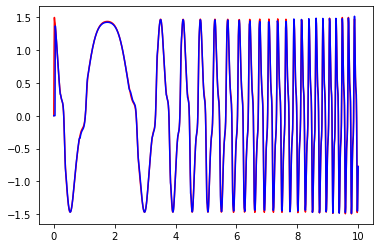

In [124]:
plt.plot(k, y, color='red')
plt.plot(k, output, color='blue')


In [125]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600, auto_order=2, exog_order=[delay], exog_delay=[delay])
narx.fit(inpt, target)

In [126]:
inputTest = u(xTest)[:, np.newaxis]
targetTest = yTest
outputTest = narx.predict(inputTest, targetTest, step=3)

In [127]:
outputTest[np.isnan(outputTest)] = 0
MSE = mean_squared_error(targetTest, outputTest)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.044698368373094786
RMSE = 0.21141988641822412


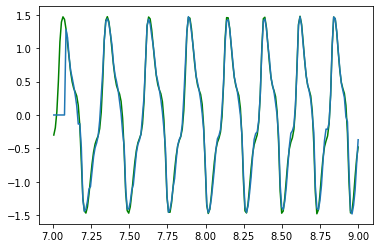

In [128]:
plt.plot(xTest, yTest, color='green')
plt.plot(xTest, outputTest)

## Выводы 
Исследовал и обучил сеть NARX, примененил её для задачи аппроксимации функций.